## Def

In [ ]:
import os
import requests
import json
import time
from datetime import datetime
from urllib.parse import urlencode

BASE_URL = 'http://localhost:1234'

def read_token(file_path='./token.txt'):
    try:
        with open(file_path, 'r') as file:
            return file.read().strip()
    except IOError as err:
        print(f'Error reading token from file: {err}')
        return None
    

def get_headers(token):
    return {
        'Authorization': f'Bearer {token}',
        'Content-Type': 'application/json'
    }

token = read_token()

def write_token(token):
    if not os.path.exists('token.txt'):
        with open('token.txt', 'w') as f:
            f.write(token)
    else:
        with open('token.txt', 'w') as f:
            f.write(token)
        
def register(user_name, pwd, email):
    try:
        response = requests.post(
            f'{BASE_URL}/users/register',
            json={
                'user_name': user_name,
                'pwd': pwd,
                'email': email,
            }
        )
        response.raise_for_status()
        token = response.json().get('token', '')
        if token:
            write_token(token)
    except requests.exceptions.RequestException as err:
        print(f'Registration error: {err}')

def login(user_name, pwd):
    try:
        response = requests.post(
            f'{BASE_URL}/users/login',
            json={
                'user_name': user_name,
                'pwd': pwd,
            }
        )
        response.raise_for_status()
        token = response.json().get('token', '')
        if token:
            write_token(token)
    except requests.exceptions.RequestException as err:
        print(f'Login error: {err}')
            
def get_all_momentum():
    try:
        response = requests.get(f'{BASE_URL}/marketIndex/momentum', headers=get_headers(token))
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as err:
        print(f'Error fetching momentum: {err}')
        return None

def get_momentum_by_range(days):
    try:
        response = requests.get(f'{BASE_URL}/marketIndex/momentum/range/{days}', headers=get_headers(token))
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as err:
        print(f'Error fetching momentum: {err}')
        return None

def parse_date(date_str):
    date_format = '%Y-%m-%d'
    try:
        date = datetime.strptime(date_str, date_format)
        return date.strftime(date_format)
    except ValueError:
        return None

def record_my_transactions(transactions):
    try:
        for stock_id, transaction_type, quantity, price, transaction_date in transactions:
            data = {
                'stock_id': stock_id,
                'transaction_type': transaction_type,
                'quantity': quantity,
                'price': price,
                'transaction_date': parse_date(transaction_date) or datetime.now().strftime('%Y-%m-%d')
            }
            response = requests.post(f'{BASE_URL}/transactions', headers=get_headers(token), json=data)
            if response.status_code in range(200, 300):
                print(f'Successfully inserted: {data}')
            else:
                print(f'Failed to insert: {data}, Status code: {response.status_code}, Response: {response.text}')
            time.sleep(2)
    except requests.exceptions.RequestException as err:
        print(f'Error recording transactions: {err}')

def get_my_portfolio():
    try:
        response = requests.get(f'{BASE_URL}/portfolio', headers=get_headers(token))
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as err:
        print(f'Error fetching portfolio: {err}')
        return None

def get_technews_by_keyword(keyword):
    try:
        response = requests.get(f"{BASE_URL}/technews/search?keyword={keyword}", headers=get_headers(token))
        response.raise_for_status()
        data = response.json()
        return data[::-1]  # 反转列表
    except requests.exceptions.RequestException as err:
        print(f'Error fetching technews: {err}')
        return None
    
def getAllTechnews (page, size):
    if not isinstance(page, int) or not isinstance(size, int) or page <= 0 or size <= 0:
        print('Valid page & size required')
        return []

    params = {
        'page': page,
        'size': size
	}
    paramsStr = urlencode(params)
    try:
        response = requests.get(f"{BASE_URL}/technews?{paramsStr}", headers=get_headers(token))
        response.raise_for_status()
        data = response.json()
        return data[::-1]  # 反转列表
    except requests.exceptions.RequestException as err:
        print(f'Error fetching technews: {err}')
        return None
    
def create_one_company_news (params):
	try:
		response = requests.post(f"{BASE_URL}/company-news", headers=get_headers(token), json=params)
		response.raise_for_status()
		return response.json()
	except requests.exceptions.RequestException as err:
		print(f'Error post company_news: {err}')
		return None
    
def get_all_company_news (page, size):
	if not isinstance(page, int) or not isinstance(page, int) or page <= 0 or size <=0:
		print('Valid page & size required')
		return []

	params = f"page={page}&size={size}"
	try:
		response = requests.get(f"{BASE_URL}/company-news?{params}", headers=get_headers(token))
		response.raise_for_status()
		return response.json()
	except requests.exceptions.RequestException as err:
		print(f'Error fetching technews: {err}')
		return None

def get_statement_by_symbol(symbol):
    try:
        url = f"{BASE_URL}/statements/{symbol}"
        response = requests.get(url, headers=get_headers(token))
        response.raise_for_status()
        data = response.json()
        return data
    except requests.exceptions.RequestException as err:
        print(f'Error fetching financial statement for {symbol}: {err}')
        return None
    
def get_user_subscribe_news():
    try:
        url = f"{BASE_URL}/subscribe/technews"
        response = requests.get(url, headers=get_headers(token))
        response.raise_for_status()
        data = response.json()
        return data
    except requests.exceptions.RequestException as err:
        print(f'Error fetching financial statement for {symbol}: {err}')
        return None
    
def user_subscribe_news(params):
    try:
        url = f"{BASE_URL}/subscribe/technews"
        response = requests.post(url, headers=get_headers(token), json=params)
        response.raise_for_status()
        data = response.json()
        return data
    except requests.exceptions.RequestException as err:
        print(f'Error fetching financial statement for {symbol}: {err}')
        return None

### 登入

In [ ]:
login(user_name='', pwd='')

#### 註冊

In [ ]:
register(user_name='', pwd='', email='')

### 取得動能指標

In [ ]:
# my_data = get_all_momentum()
# print(my_data)

my_data = get_momentum_by_range(7)
print(my_data)

#### 畫出動能

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

# 将数据转换为 DataFrame
df = pd.DataFrame(my_data)

# 将 'createdAt' 列转换为日期时间对象
df['createdAt'] = pd.to_datetime(df['createdAt'])

# 绘制时间序列数据
plt.figure(figsize=(10, 6))
plt.plot(df['createdAt'], df['volume'], marker='o', linestyle='-', color='#efb441')

# 格式化 x 轴的时间显示
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))

# 设置标题和标签
plt.title('Time Series Momentum')
plt.xlabel('Time')
plt.ylabel('Volume')

# 显示网格
plt.grid(True)

# 自动调整 x 轴日期标签显示
plt.gcf().autofmt_xdate()

# 显示图形
plt.show()

### 記錄交易

In [ ]:
transactions = [
	('ANET', 'buy', 7, 106.62 , '2025-2-14'),
]

In [ ]:
record_my_transactions(transactions)

### MY Portfolio

In [ ]:
import math
my_portfolio = get_my_portfolio()
for item in my_portfolio:
	quantity = item.get('quantity', '?')
	average_price = item.get('average_price', '?')
	stock_id = item.get('stock_id', '?')
	print(stock_id + ' ' + str(quantity) + ' * ' + str(average_price) + ' = ' + str(math.ceil(float(quantity) * float(average_price)))  + '\n')

In [ ]:
import matplotlib.pyplot as plt

# 计算每个 stock_id 的总价值
portfolio_values = {}
for item in my_portfolio:
    stock_id = item['stock_id']
    quantity = item['quantity']
    average_price = float(item['average_price'])  # 转换为浮点数
    total_value = quantity * average_price
    if stock_id in portfolio_values:
        portfolio_values[stock_id] += total_value
    else:
        portfolio_values[stock_id] = total_value

# 计算投资组合中剩余的 USD 价值
portfolio_values['USD'] = 2000

portfolio_values = {k: v for k, v in portfolio_values.items() if v > 0}

sorted_portfolio_values = dict(sorted(portfolio_values.items(), key=lambda item: item[1], reverse=True))

# 准备数据绘制饼图
labels = sorted_portfolio_values.keys()
sizes = sorted_portfolio_values.values()
colors = plt.get_cmap('Set2').colors  # 使用预设的颜色映射
explode = [0.1] * len(labels)  # 使每个切片稍微突出

# 绘制饼图
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Portfolio Distribution by Stock')
plt.show()

### search news by keyword

In [ ]:
keyword = 'ai'

news = get_technews_by_keyword(keyword)

for item in news:
	id = item.get('id', 'No id')
	title = item.get('title', 'No Title')
	time = item.get('release_time', 'No Time')
	web_url = item.get('web_url', '')
	print(str(id) + ' : ' + title + ' ' + time + '\n')
	print(web_url + '\n')
	print('----------')

In [ ]:
all_news = getAllTechnews(page=1, size=5000)
for item in all_news:
	title = item.get('title', 'No Title')
	time = item.get('release_time', 'No Time')
	web_url = item.get('web_url', '')
	print(title + ' ' + time + '\n')
	print(web_url + '\n')
	print('----------')

#### 搜索Company news

In [ ]:
all_news = get_all_company_news(page=1, size=10)

for item in all_news:
	company_name = item.get('companyName', '? companyName')
	title = item.get('title', 'No Title')
	time = item.get('release_time', 'No Time')
	web_url = item.get('web_url', '')
	print(company_name + ':'+ '\n')
	print(title + ' ' + time + '\n')
	print(web_url + '\n')
	print('----------')

#### 讀取Html 轉成json資料

In [ ]:
symbol = 'ANET'

In [ ]:
from bs4 import BeautifulSoup
from datetime import datetime, timezone

with open('index.html', 'r', encoding='utf-8') as file:
	html_content = file.read()

soup = BeautifulSoup(html_content, 'html.parser')

news = []

for row in soup.find_all('tr', class_='cursor-pointer has-label'):
	time_cell = row.find('td', align='right')
	time_text = time_cell.get_text(strip=True).replace('Today', '')

	if 'Today' in time_text:
		time_text = time_text.replace('Today', '')
		now = datetime.now(timezone.utc)
		date_str = now.date().isoformat()
	else:
		now = datetime.now(timezone.utc)
		date_str = now.date().isoformat()

	try:
		time_obj = datetime.strptime(time_text, '%I:%M%p')
		time_24hr = time_obj.strftime('%H:%M:%S')
	except ValueError:
		# 如果时间格式无法解析，使用默认时间
		time_24hr = '00:00:00'
		
	# 创建 MySQL 支持的时间字符串
	release_time = f"{date_str} {time_24hr}"

	link = row.find('a', class_='tab-link-news')
	title = link.get_text(strip=True)
	web_url = link['href']

	publisher = row.find('span').get_text(strip=True).strip('()')

	news_item = {
        "title": title,
        "symbol": symbol,
        "release_time": release_time,
        "publisher": publisher,
        "web_url": web_url
    }

	news.append(news_item)

print(json.dumps(news, indent=4))


#### 多筆寫入至資料庫 Company_news

In [ ]:
url = BASE_URL + '/company-news/bulk'

response = requests.post(url, headers=headers, json=news)

print(f"Status Code: {response.status_code}")
print("Response Text:", response.text)

try:
    response_data = response.json()
    print(json.dumps(response_data, indent=2))
except ValueError as e:
    # 捕获并打印异常详细信息
    print(f"Failed to parse JSON: {e}")
    print("Response Text:", response.text)

#### 單筆寫入

In [ ]:
from time import sleep

for item in news:
	res = create_one_company_news(item)
	print(res)
	sleep(1)

#### 取得statement

In [ ]:
symbo = 'nvda'

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_pe_forward_vs_time(data):
    # 提取 'createdAt' 和 'PE_Forward' 数据
    timestamps = []
    pe_forward_values = []
    
    for entry in data:
        # 解析时间字段
        created_at = entry.get('createdAt', '')
        pe_forward = entry.get('PE_Forward', None)
        
        if created_at and pe_forward is not None:
            # 将 'createdAt' 转换为 datetime 对象
            timestamp = datetime.strptime(created_at, "%Y-%m-%dT%H:%M:%S.%fZ")
            timestamps.append(timestamp)
            
            # 将 'PE_Forward' 转换为浮动数字
            pe_forward_values.append(float(pe_forward))
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, pe_forward_values, marker='o', linestyle='-', color='#efb441', label='PE Forward')

    # 设置标题和标签
    plt.title('PE Forward vs Time')
    plt.xlabel('Date')
    plt.ylabel('PE Forward')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.gcf().autofmt_xdate()  # 自动旋转日期标签，使其更易读

    # 显示图例
    plt.legend()

    # 显示图表
    plt.tight_layout()
    plt.show()

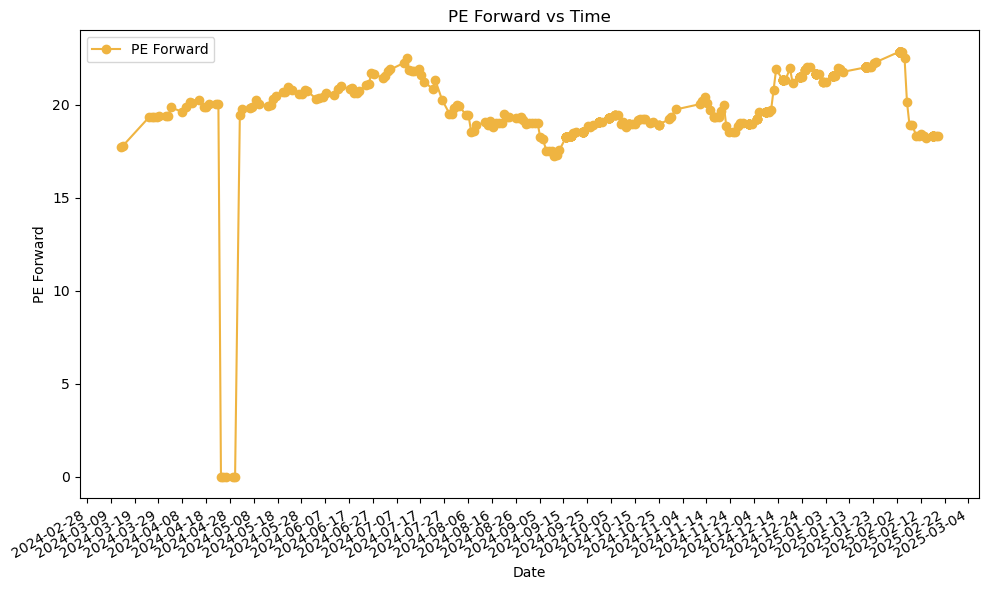

In [43]:
response = get_statement_by_symbol('goog')
    
plot_pe_forward_vs_time(response)

In [ ]:
# user_subscribe_news({'newsId': 80497})
data = get_user_subscribe_news()
data